# Predicting Total Cup

# Description 
Experiments with a DecisionTreeClassifier and a RandomForestClassifier to predict total cup score without the 10 quality measures.

# Project Name: Not a Latte cool beans
# Date: 5/15/2022

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
import matplotlib.pyplot as plt

In [2]:
# Let's start by loading in our train and test datasets
df_train = pd.read_csv('train_data.csv')
df_test = pd.read_csv('test_data_balanced.csv')

df_test.head(3)

,Species,Country.of.Origin,Number.of.Bags,In.Country.Partner,Variety,Processing.Method,Aroma,Flavor,Aftertaste,Acidity,...,Sweetness,Cupper.Points,Moisture,Category.One.Defects,Quakers,Color,Category.Two.Defects,altitude_low_meters,altitude_high_meters,quality
0,Arabica,Colombia,275,Almacafé,Caturra,Washed / Wet,7.67,7.75,7.42,7.83,...,10.0,7.42,0.11,0,0.0,Green,1,1650.0,1650.0,excellent
1,Arabica,Honduras,275,Instituto Hondureño del Café,Caturra,Washed / Wet,7.50,7.58,7.33,7.50,...,10.0,7.58,0.10,0,1.0,Green,8,1396.0,1396.0,excellent
2,Arabica,Mexico,10,AMECAFE,Bourbon,Washed / Wet,7.50,7.58,7.42,7.67,...,10.0,7.33,0.13,0,0.0,Green,3,1170.0,1170.0,excellent


In [3]:
df_test.columns

Index(['Species', 'Country.of.Origin', 'Number.of.Bags', 'In.Country.Partner',
       'Variety', 'Processing.Method', 'Aroma', 'Flavor', 'Aftertaste',
       'Acidity', 'Body', 'Balance', 'Uniformity', 'Clean.Cup', 'Sweetness',
       'Cupper.Points', 'Moisture', 'Category.One.Defects', 'Quakers', 'Color',
       'Category.Two.Defects', 'altitude_low_meters', 'altitude_high_meters',
       'quality'],
      dtype='object')

In [4]:
# So now we've loaded in our datasets, first order of business is to drop the
# quality measure columns
df_train = df_train.drop(['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance',
       'Uniformity', 'Clean.Cup', 'Sweetness', 'Cupper.Points', 'Total.Cup.Points', 'Country.of.Origin', 'In.Country.Partner', 'Variety'], axis=1)
df_test = df_test.drop(['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance',
       'Uniformity', 'Clean.Cup', 'Sweetness', 'Cupper.Points', 'Country.of.Origin', 'In.Country.Partner', 'Variety'],axis=1)

# And we'll also shuffle for good measure
df_train = df_train.sample(frac=1.0, random_state=0)
df_test = df_test.sample(frac=1.0, random_state=0)

df_train.head(3)

,Species,Number.of.Bags,Processing.Method,Moisture,Category.One.Defects,Quakers,Color,Category.Two.Defects,altitude_low_meters,altitude_high_meters,quality
1034,Arabica,50,Washed / Wet,0.10,0,0.0,Blue-Green,0,500.0,700.0,very good
124,Arabica,10,Natural / Dry,0.15,1,0.0,None,8,441.0,441.0,excellent
184,Arabica,44,Washed / Wet,0.11,0,0.0,Green,2,950.0,950.0,excellent


In [5]:
# Now we can define our target and features
X_train = df_train.drop(['quality'], axis=1)
X_test = df_test.drop(['quality'], axis=1)

y_train = df_train['quality']
y_test = df_test['quality']

In [6]:
# We'll get dummies for the categorical data and standardize the numerical columns
X_train_num = X_train.select_dtypes(include='number')
X_train_cat = X_train.select_dtypes(exclude='number')

X_train_cat = pd.get_dummies(X_train_cat)
X_train_num = (X_train_num - X_train_num.mean()) / X_train_num.std()

X_train = pd.concat([X_train_num, X_train_cat], axis=1)

X_test_num = X_test.select_dtypes(include='number')
X_test_cat = X_test.select_dtypes(exclude='number')

X_test_cat = pd.get_dummies(X_test_cat)
X_test_num = (X_test_num - X_test_num.mean()) / X_test_num.std()

X_test = pd.concat([X_test_num, X_test_cat], axis=1)

In [7]:
print(X_train.shape)
X_train.head(3)

(1244, 18)


,Number.of.Bags,Moisture,Category.One.Defects,Quakers,Category.Two.Defects,altitude_low_meters,altitude_high_meters,Species_Arabica,Species_Robusta,Processing.Method_Natural / Dry,Processing.Method_Other,Processing.Method_Pulped natural / honey,Processing.Method_Semi-washed / Semi-pulped,Processing.Method_Washed / Wet,Color_Blue-Green,Color_Bluish-Green,Color_Green,Color_None
1034,-0.807907,-0.039962,-0.269278,-0.175172,-0.744302,-0.129194,-0.114575,1,0,0,0,0,0,1,1,0,0,0
124,-1.126193,1.196664,0.102511,-0.175172,0.372432,-0.134124,-0.136221,1,0,1,0,0,0,0,0,0,0,1
184,-0.855650,0.207363,-0.269278,-0.175172,-0.465119,-0.091589,-0.093681,1,0,0,0,0,0,1,0,0,1,0


In [8]:
y_test.value_counts()

very good    161
excellent    161
Name: quality, dtype: int64

In [9]:
# Now let's set up our DecisionTreeClassifier
grid = {'max_depth': np.arange(1, 40)}

Tree = DecisionTreeClassifier()
TreeCV = GridSearchCV(Tree, param_grid=grid, return_train_score=True)

TreeCV.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39])},
             return_train_score=True)

In [10]:
print('best depth', TreeCV.best_params_['max_depth'])
print('validation accuracy', TreeCV.best_score_.round(3))

best depth 21
validation accuracy 0.939


In [11]:
best_tree = DecisionTreeClassifier(max_depth=TreeCV.best_params_['max_depth'])
best_tree.fit(X_train, y_train)
print(best_tree.score(X_test, y_test).round(3))

0.665


In [12]:
print(X_train.shape)

(1244, 18)


<AxesSubplot:xlabel='depth'>

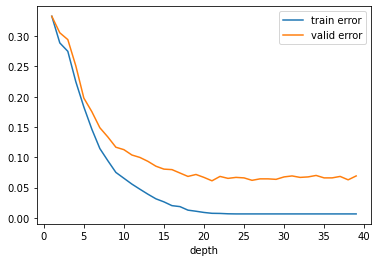

In [13]:
results = pd.DataFrame()
results['depth'] = grid['max_depth']
results['train error'] = 1 - TreeCV.cv_results_['mean_train_score']
results['valid error'] = 1 - TreeCV.cv_results_['mean_test_score']
ax1 = results.plot.line(x='depth', y='train error')
results.plot.line(x='depth', y='valid error', ax=ax1)

Text(89.18, 0.5, 'predicted label')

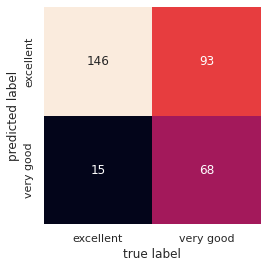

In [14]:
y_fit = best_tree.predict(X_test)
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_fit,labels=['excellent','very good'])
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['excellent','very good'],
            yticklabels=['excellent','very good'])
plt.xlabel('true label')
plt.ylabel('predicted label')

In [15]:
y_test[0:4]

293    very good
65     excellent
15     excellent
272    very good
Name: quality, dtype: object

# It's random forest time

In [16]:
# Luckily, our trai ning and test data is already defined in terms of targets and features

#grid = {'n_estimators': np.arange(1, 20), 'max_depth': np.arange(1, 30)}
grid = {'n_estimators': np.arange(1, 20)}

rf = RandomForestClassifier(max_depth=25)
rfCV = GridSearchCV(rf, param_grid=grid, return_train_score=True, n_jobs=-1)

In [17]:
rfCV.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(max_depth=25), n_jobs=-1,
             param_grid={'n_estimators': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])},
             return_train_score=True)

In [18]:
#print('n_estimators: ', rfCV.best_params_['n_estimators'], '  max_depth: ', rfCV.best_params_['max_depth'])
print('n_estimators: ', rfCV.best_params_['n_estimators'])
print('validation accuracy ', rfCV.best_score_.round(3))

n_estimators:  18
validation accuracy  0.953


In [19]:
# Now let's see how we do 
# best_forest = RandomForestClassifier(n_estimators=rfCV.best_params_['n_estimators'],max_depth=rfCV.best_params_['max_depth'])
best_forest = RandomForestClassifier(n_estimators=rfCV.best_params_['n_estimators'],max_depth=25)
best_forest.fit(X_train, y_train)
print(best_forest.score(X_train, y_train).round(3))
print(best_forest.score(X_test, y_test).round(3))

0.994
0.652


<AxesSubplot:xlabel='number of trees'>

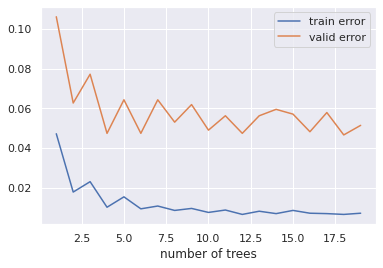

In [20]:
results = pd.DataFrame()
results['number of trees'] = grid['n_estimators']
results['train error'] = 1 - rfCV.cv_results_['mean_train_score']
results['valid error'] = 1 - rfCV.cv_results_['mean_test_score']
ax1 = results.plot.line(x='number of trees', y='train error')
results.plot.line(x='number of trees', y='valid error', ax=ax1)

Text(89.18, 0.5, 'predicted label')

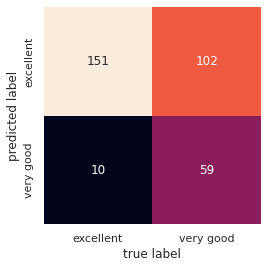

In [21]:
y_fit = best_forest.predict(X_test)
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_fit,labels=['excellent','very good'])
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['excellent','very good'],
            yticklabels=['excellent','very good'])
plt.xlabel('true label')
plt.ylabel('predicted label')

In [22]:
feature_importance = pd.Series(best_forest.feature_importances_, index=X_train.columns)
feature_importance.sort_values(ascending=False)

Category.Two.Defects                           0.205716
altitude_high_meters                           0.167845
altitude_low_meters                            0.148616
Number.of.Bags                                 0.147534
Moisture                                       0.132404
Processing.Method_Washed / Wet                 0.036224
Category.One.Defects                           0.030567
Color_None                                     0.029233
Quakers                                        0.022422
Color_Green                                    0.018163
Color_Bluish-Green                             0.014789
Processing.Method_Natural / Dry                0.014610
Processing.Method_Semi-washed / Semi-pulped    0.014133
Color_Blue-Green                               0.008217
Processing.Method_Other                        0.004267
Species_Arabica                                0.003176
Species_Robusta                                0.001759
Processing.Method_Pulped natural / honey       0

<AxesSubplot:>

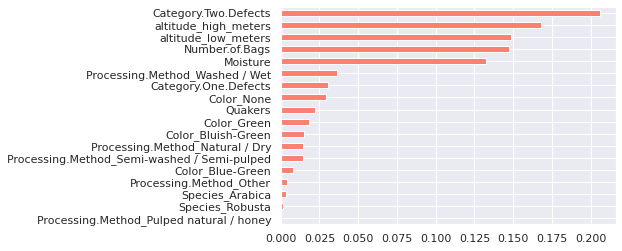

In [23]:
feature_importance.sort_values().plot.barh(color='salmon')